In [213]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import scikitplot as skplt

import nltk
from nltk.corpus import stopwords

import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sb

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument 
from gensim.models import Doc2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

plt.style.use('dark_background')

from datetime import datetime
import pytz
import time

import os
import pickle

### Reading the data

In [14]:
if os.path.isfile("data/raw_data.pkl"): 
    with open("data/raw_data.pkl", "br") as f:
        raw_data = pickle.load(f)
    print("Raw data read from 'raw_data.pkl'.")
else:
    fake_news = pd.read_csv("data/fake.csv.zip", parse_dates=['published'])
    articles1 = pd.read_csv("data/articles1.csv.zip")
    articles2 = pd.read_csv("data/articles2.csv.zip")
    articles3 = pd.read_csv("data/articles3.csv.zip")
    
    true_news = pd.concat([articles1, articles2, articles3])
    true_news = true_news[['publication', 'title', 'author', 'content']]
    true_news = true_news.loc[true_news.publication.isin(['New York Times'])]
    true_news = true_news[['title', 'author', 'content']]
    true_news['label'] = 0
    
    tz = pytz.timezone('America/Chicago')
    fake_news = fake_news.loc[fake_news.language == 'english']
    fake_news = fake_news.loc[fake_news.published > tz.localize(datetime.strptime('2016-11-01', '%Y-%m-%d'))]
    fake_news = fake_news[['title', 'author', 'text']]
    fake_news.rename(columns={'text':'content'}, inplace=True)
    fake_news['label'] = 1
    
    raw_data = pd.concat([true_news, fake_news])
    raw_data = raw_data.loc[(raw_data.title.isna() == False) & (raw_data.content.isna() == False)]
    raw_data = raw_data.sample(frac=1).reset_index(drop=True)
    
    with open("data/raw_data.pkl", "bw") as f:
        pickle.dump(raw_data, f)
    print("Raw data written to 'raw_data.pkl'.")

Raw data read from 'raw_data.pkl'.


In [15]:
raw_data.head()

,title,author,content,label
0,John Kerry’s Trip to the South Pole: Nazi Root...,Author,Region: USA in the World So why did the US Sec...,1
1,John Kerry Is Said to Side With Diplomats’ Cri...,Mark Landler,WASHINGTON — For a cabinet member whose dep...,0
2,Tim Kaine Compares Donald Trump’s Comments on ...,Yamiche Alcindor,Senator Tim Kaine of Virginia on Sunday compar...,0
3,"Revel in the Bounty of Spring, With a Feast Fr...",Sam Sifton,The first thing Yotam Ottolenghi did before he...,0
4,"In Betsy DeVos for Education, Trump Taps Into ...","Vanessa Friedman, Maggie Haberman and Alan Rap...",Donald J. Trump has reached into Western Mic...,0


### Preprocessing

In [16]:
stop_words = stopwords.words('english')

def remove_stopwords(corpus):
    corpus = [[word for word in simple_preprocess(doc, min_len=3, deacc=True) if word not in stop_words] for doc in corpus]
    return [' '.join(word) for word in corpus]

def lemmatize(corpus):
    corpus = [[token.lemma_ for token in doc] for doc in nlp.pipe(corpus, batch_size=3000, n_threads=-1)]
    return [' '.join(word) for word in corpus]

In [17]:
time_ = datetime.now()
if os.path.isfile("data/preprocessed_data.pkl"): 
    with open("data/preprocessed_data.pkl", "br") as f:
        preprocessed_data = pickle.load(f)
    print("Preprocessed data read from 'preprocessed_data.pkl'.")
    
else:
    preprocessed_data = pd.DataFrame(columns=['title', 'author', 'content'], index=raw_data.index)
    
    preprocessed_data['title'] = remove_stopwords(raw_data.title)
    preprocessed_data['content'] = remove_stopwords(raw_data.content)
    preprocessed_data['author'] = raw_data.author
    preprocessed_data['label'] = raw_data.label
    
    preprocessed_data['title'] = lemmatize(preprocessed_data.title)
    preprocessed_data['content'] = lemmatize(preprocessed_data.content)
    
    with open("data/preprocessed_data.pkl", "bw") as f:
        pickle.dump(preprocessed_data, f)
    print("Preprocessed data written to 'preprocessed_data.pkl'.")

time_ = datetime.now() - time_

Preprocessed data written to 'preprocessed_data.pkl'.


In [18]:
time_

datetime.timedelta(seconds=1611, microseconds=904669)

In [19]:
preprocessed_data.head()

,title,author,content,label
0,john kerry trip south pole nazi root revisit n...,Author,region usa world secretary state john kerry go...,1
1,john kerry say side diplomat critical memo syr...,Mark Landler,washington cabinet member whose department eru...,0
2,tim kaine compare donald trump comment russian...,Yamiche Alcindor,senator tim kaine virginia sunday compare dona...,0
3,revel bounty spring feast yotam ottolenghi new...,Sam Sifton,first thing yotam ottolenghi begin cook feast ...,0
4,betsy devos education trump tap michigan royal...,"Vanessa Friedman, Maggie Haberman and Alan Rap...",donald trump reach western michigan royalty pi...,0


### Modeling

__Naive Bayes Classifier__
<br>
<br>
Naive Bayes classifier models $p(x, y)$. In computing $p(x|y)$, we take a strong assumption that features ($x_{i}'s$) are conditionally independent given y. This assumption is called `Naive Bayes assumption` and the resulting aalgorithm is called `Naive Bayes classifier`. 
<br>
<br>
`Model inputs:`
<br>
- In our model, $x^{(i)}_{j}$ is 1 or 0 depending on whether the $i^{th}$ word is presnt in $j^{th}$ document or not.
- $y^{i}$ represents whether the document (news) is fake (1) or not (0).
<br>

`Model parameters:`
<br>
> <font color=green>$\phi_{j|y=1} = p(x_{j} = 1 | y = 1)$</font>
<br>
> <font color=green>$\phi_{j|y=0} = p(x_{j} = 1 | y = 0)$</font>
<br>
> <font color=green>$\phi_{y} = p(y = 1)$</font>

In [20]:
"""Select training and test data size (80% & 20% chosen in this case)"""
train_size = int(0.8 * len(preprocessed_data))
test_size = len(preprocessed_data) - train_size

"""Transform the text into document-term matrix using CountVectorizer"""
"""Binary CountVectorizer represents a word in a binary format i.e. 1 if it is present, 0 if it is not present in the document)"""
vectorizer = CountVectorizer(stop_words='english', min_df=100, binary=True)
dtm_matrix = vectorizer.fit_transform(preprocessed_data.content.values)

"""Select training and test data,  we don't need cross validation data as no hyper-params in the model"""
train_data = dtm_matrix[:train_size]
train_labels = preprocessed_data.label.values[:train_size]

test_data = dtm_matrix[train_size:]
test_labels = preprocessed_data.label.values[train_size:]

In [21]:
train_data

<10865x5556 sparse matrix of type '<class 'numpy.int64'>'
	with 2529123 stored elements in Compressed Sparse Row format>

In [208]:
"""Fit the Naive Bayes model"""
nb_clf = BernoulliNB()
nb_clf.fit(train_data, train_labels)

"""Compute training accuracy score"""
print("Training accuracy score: %.4f" % nb_clf.score(train_data, train_labels))

"""Predict labels for test documents"""
test_pred = nb_clf.predict(test_data)

"""Compute the test accuracy score"""
print("Training accuracy score: %.4f" % (np.sum(test_pred == test_labels)/len(test_pred)))

Training accuracy score: 0.8237
Training accuracy score: 0.8211


In [211]:
def draw_conf_matrix(test_labels, test_pred):
    skplt.metrics.plot_confusion_matrix(test_labels, test_pred, figsize=(8, 6), normalize=True)
    plt.show()

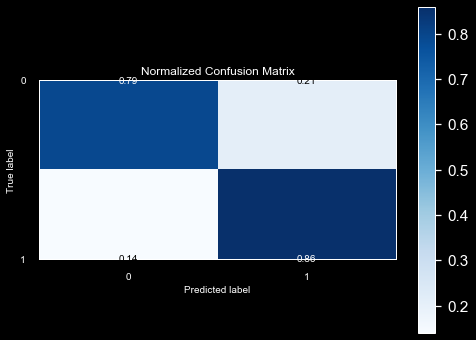

In [212]:
draw_conf_matrix(test_labels, test_pred)

In [210]:
def find_words_from_indices(indices):
    arr = np.zeros(nb_clf.feature_count_.shape[1])

    for i in indices:
        arr[i] = 1
    return vectorizer.inverse_transform(arr)

In [73]:
"""feature probabilities for fake news"""
highest_posterior_prob_indices = np.flip(np.argsort(np.exp(nb_clf.feature_log_prob_)[1]))[:20]

In [192]:
"""Find words with highest posterior probability"""
"""Highest posterior probability means that if the next news you read is fake news then there is 
high probability that you will see the following words"""

print(find_words_from_indices(highest_posterior_prob_indices))

[array(['come', 'day', 'election', 'know', 'like', 'make', 'new',
       'november', 'people', 'president', 'right', 'say', 'state', 'time',
       'trump', 'use', 'way', 'work', 'world', 'year'], dtype='<U15')]


`Observation`
- We can see that trump, president and state has appreared a lot in the fake news

`Ranking of words`
<br>
- We will create ranking of words using the following formula
> <font color=green>$rank = \frac{\exp({\phi_{j|y=1}})}{\exp({\phi_{j|y=0}})}$</font>
- Highest and lowest ranks can be interpreted as the most indicative words in the classification of the document; highest rank indicate that the news is fake, lowest rank indicate that the news is genuine
- We will find the k most indicative tokens, of which k/2 have the highest rank and k/2 have the lowest rank 

In [199]:
"""ranking of words in the fake news"""
k = 60
rank = np.exp(np.exp(nb_clf.feature_log_prob_)[1])/np.exp(np.exp(nb_clf.feature_log_prob_)[0])

"""Highest ranking words in the fake news"""
indices = np.argsort(rank)[-int(k/2):]
print("\nHighest ranking words in the fake news")
print(find_words_from_indices(indices))

"""Lowest ranking words in the fake news"""
indices = np.argsort(rank)[:int(k/2)]
print("\nLowest ranking words in the fake news")
print(find_words_from_indices(indices))


Highest ranking words in the fake news
[array(['anti', 'article', 'cia', 'click', 'clinton', 'com', 'corrupt',
       'currently', 'destroy', 'elect', 'election', 'establishment',
       'fact', 'fbi', 'hillary', 'http', 'mainstream', 'massive',
       'medium', 'non', 'november', 'post', 'propaganda', 'regime',
       'self', 'share', 'source', 'truth', 'usa', 'wikileak'],
      dtype='<U15')]

Lowest ranking words in the fake news
[array(['add', 'ask', 'begin', 'city', 'come', 'day', 'early', 'executive',
       'group', 'help', 'include', 'interview', 'know', 'later', 'like',
       'make', 'month', 'new', 'official', 'people', 'say', 'states',
       'time', 'try', 'united', 'want', 'week', 'work', 'year', 'york'],
      dtype='<U15')]


`Observation:`
<br>
- We can see that fake articles tend to use more radical words

__SVM Classifier__
<br>
<br>
`Support vector machines (SVM)` find the optimal hyperplane in the feature space to classify the dataset. SVM can be pretty useful if the feature space is very high dimensional. It uses the kernel trick to efficiently find the optimal solution. I have chosen to use Gaussian kernel based on the idea that the documents which are closer in euclidean distance should belong to the same class. Gaussian kernel (aka `Radial Basis Function`) is defined as

> <font color='green'>$K(\text{x}^i, \text{x}^j) = -\lambda \exp(||\text{x}^i - \text{x}^j||^2)$</font>
<br>

We have two `hyperparameters` - 
1. <font color='green'>$C$</font> : $C$ is inversely proportional to the strength of regularization
2. <font color='green'>$\lambda$</font> : higher $\lambda$ means the solution overfits, lower $\lambda$ means the solution underfits

In [214]:
"""Select training, cross-validation and test data size (70%, 15% & 15% chosen in this case)"""
train_size = int(0.7 * len(preprocessed_data))
cv_size = int(0.15 * len(preprocessed_data))

"""Select training, cross-validation and test data"""
train_data = dtm_matrix[:train_size]
train_labels = preprocessed_data.label.values[:train_size]

cv_data = dtm_matrix[train_size:train_size+cv_size]
cv_labels = preprocessed_data.label.values[train_size:train_size+cv_size]

test_data = dtm_matrix[train_size+cv_size:]
test_labels = preprocessed_data.label.values[train_size+cv_size:]

In [254]:
C = [0.1, 1]
lam = [1/64]

In [ ]:
time_ = datetime.now()
train_res = []
cv_res = []
for c in C:
    for l in lam:
        clf = svm.SVC(kernel="rbf", C=c, gamma=l)
        clf.fit(train_data, train_labels)
        train_res.append(clf.score(train_data, train_labels))
        cv_res.append(clf.score(cv_data, cv_labels))
        
time_ = datetime.now() - time_

In [250]:
time_/60

datetime.timedelta(seconds=9, microseconds=367007)

In [251]:
train_res

[0.9998948143473231]

In [252]:
cv_res

[0.6013745704467354]

In [222]:
test_pred = clf.predict(test_data)
np.sum(test_pred == test_labels)/len(test_pred)

0.9646712463199215

In [223]:
cv_pred = clf.predict(cv_data)
np.sum(cv_pred == cv_labels)/len(cv_pred)

0.9710358370152185

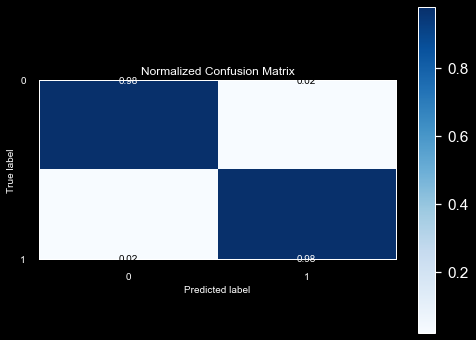

In [220]:
draw_conf_matrix(cv_labels, cv_pred)